In [1]:
## Import libraries

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(stringr)

In [3]:
# It is important to emphasize that some samples do not have timestamps because it is not provided 
# for 'scheduled' status. But, I dont know its reason.

In [3]:
df_log <- read.csv(file = 'events.csv', sep = ',', stringsAsFactors = FALSE)
df_log$creation_timestamp <- as.POSIXct(df_log$creation_timestamp,format='%Y-%m-%dT%H:%M:%SZ', tzone = "UTC")
df_log$timestamp <- as.numeric(df_log$creation_timestamp)
df_log$timestamp[is.na(df_log$timestamp)] <- Inf

df_log <- df_log %>% 
  distinct() %>%
  group_by(uid) %>%
  mutate(min_timestamp = min(timestamp)) %>%
  ungroup()
summary(df_log)

     uid                name           function_name     
 Length:130         Length:130         Length:130        
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
 creation_timestamp            first_timestamp    last_timestamp    
 Min.   :2021-07-15 14:42:54   Length:130         Length:130        
 1st Qu.:2021-07-15 14:43:25   Class :character   Class :character  
 Median :2021-07-15 14:44:14   Mode  :character   Mode  :character  
 Mean   :2021-07-15 14:45:19                                        
 3rd Qu.:2021-07-15 14:46:27                                        
 Max.   :2021-07-15 14:58:40                                        
    reason              node             message            timestamp        
 Length:130         Length:130   

In [4]:
df_activations <- read.csv(file = 'activations.csv', sep = ',', stringsAsFactors = FALSE)
summary(df_activations)

  object_uid        object_name        function_name         duration        
 Length:111         Length:111         Length:111         Min.   :  0.00998  
 Class :character   Class :character   Class :character   1st Qu.:  0.03914  
 Mode  :character   Mode  :character   Mode  :character   Median :  1.10791  
                                                          Mean   : 18.68377  
                                                          3rd Qu.:  6.31607  
                                                          Max.   :296.03821  
                                                          NA's   :69         
   timestamp            reason          metadata_value  metadata_description
 Min.   :1.626e+09   Length:111         Min.   :1.000   Length:111          
 1st Qu.:1.626e+09   Class :character   1st Qu.:1.000   Class :character    
 Median :1.626e+09   Mode  :character   Median :2.000   Mode  :character    
 Mean   :1.626e+09                      Mean   :1.957               

In [6]:
####################################

In [7]:
# Duration analysis

In [8]:
####################################

In [9]:
### Filter the events file

In [5]:
df_filtered <- df_log %>%
    filter(
      #reason == 'Scheduled' |
      reason == 'Pulling' |
      reason == 'Pulled' |
      reason == 'Created' |
      reason == 'Started' )#|
      #reason == 'Killing') %>%

df_selected <- df_filtered %>%
    mutate(duration = abs(timestamp - min_timestamp)) %>%
    select(-name, -uid, -message, -min_timestamp, -creation_timestamp, -first_timestamp, -last_timestamp, -timestamp)
summary(df_selected)

 function_name         reason              node              duration    
 Length:86          Length:86          Length:86          Min.   : 1.00  
 Class :character   Class :character   Class :character   1st Qu.: 3.00  
 Mode  :character   Mode  :character   Mode  :character   Median : 9.00  
                                                          Mean   :14.57  
                                                          3rd Qu.:19.75  
                                                          Max.   :59.00  

In [11]:
### Process the events durations

In [6]:
df_spread <- df_selected %>%
    group_by_at(vars(-duration)) %>%
    mutate(sample_id = row_number()) %>% ungroup() %>%
    spread(reason, duration) %>%
    select(-sample_id)
print(df_spread)

df_processed <- df_spread %>%
    group_by(function_name) %>%
    mutate(
        #container_scheduling = abs(Scheduled - Pulling),
        container_image_downloading = abs(Pulled - Pulling),
        container_image_creation = abs(Created - Pulled),
        container_initialization = abs(Started - Created)) %>%#,
        #container_removal = abs(Killing - Started)) %>%
    select(
        function_name,
        node,
        #container_scheduling,
        container_image_downloading,
        container_image_creation,
        container_initialization)#,
        #container_removal)
head(df_processed)

# A tibble: 23 x 6
   function_name    node                          Created Pulled Pulling Started
   <chr>            <chr>                           <dbl>  <dbl>   <dbl>   <dbl>
 1 chameleon2       paranoia-8.rennes.grid5000.fr      28     25       2      28
 2 chameleon3       paranoia-2.rennes.grid5000.fr      17     14       4      18
 3 facedetection1   paranoia-8.rennes.grid5000.fr       9      8       1      10
 4 facedetection2   paranoia-8.rennes.grid5000.fr       2      2      NA       2
 5 facedetection3   paranoia-8.rennes.grid5000.fr       2      2      NA       3
 6 floatoperation1  paranoia-8.rennes.grid5000.fr      18     16       2      19
 7 floatoperation2  paranoia-8.rennes.grid5000.fr      18     16       2      19
 8 floatoperation3  paranoia-2.rennes.grid5000.fr      17     14       2      17
 9 imageprocessing1 paranoia-8.rennes.grid5000.fr      47     44      18      48
10 imageprocessing2 paranoia-8.rennes.grid5000.fr      38     36       9      39
# … with 

function_name   node                          container_image_downloading
1 chameleon2      paranoia-8.rennes.grid5000.fr 23                         
2 chameleon3      paranoia-2.rennes.grid5000.fr 10                         
3 facedetection1  paranoia-8.rennes.grid5000.fr  7                         
4 facedetection2  paranoia-8.rennes.grid5000.fr NA                         
5 facedetection3  paranoia-8.rennes.grid5000.fr NA                         
6 floatoperation1 paranoia-8.rennes.grid5000.fr 14                         
  container_image_creation container_initialization
1 3                        0                       
2 3                        1                       
3 1                        1                       
4 0                        0                       
5 0                        1                       
6 2                        1

In [13]:
### Filter the activations file

In [7]:
df_activations_selected <- df_activations %>%
    select(
        function_name,
        duration,
        reason,
        node,
        object_uid) #%>%
        #mutate(duration = (duration / 1000) %% 60)
summary(df_activations_selected)

 function_name         duration            reason            node        
 Length:111         Min.   :  0.00998   Length:111         Mode:logical  
 Class :character   1st Qu.:  0.03914   Class :character   NA's:111      
 Mode  :character   Median :  1.10791   Mode  :character                 
                    Mean   : 18.68377                                    
                    3rd Qu.:  6.31607                                    
                    Max.   :296.03821                                    
                    NA's   :69                                           
  object_uid       
 Length:111        
 Class :character  
 Mode  :character  
                   
                   
                   
                   

In [15]:
### First view of activations

'data.frame':	111 obs. of  5 variables:
 $ function_name: chr  "rnngenerate2" "rnngenerate2" "rnngenerate2" "rnngenerate2" ...
 $ duration     : num  0.0313 0.0337 NA NA NA ...
 $ reason       : chr  "download_data" "function_execution" "finishing_time" "starting_time" ...
 $ node         : logi  NA NA NA NA NA NA ...
 $ object_uid   : chr  "0adff090f21447069ff090f214270602" "0adff090f21447069ff090f214270602" "0adff090f21447069ff090f214270602" "0adff090f21447069ff090f214270602" ...


Saving 6.67 x 6.67 in image

Warning message:
“Removed 69 rows containing missing values (position_stack).”
Warning message:
“Removed 69 rows containing missing values (position_stack).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 69 rows containing missing values (geom_point).”
Warning message:
“Removed 69 rows containing missing values (geom_point).”


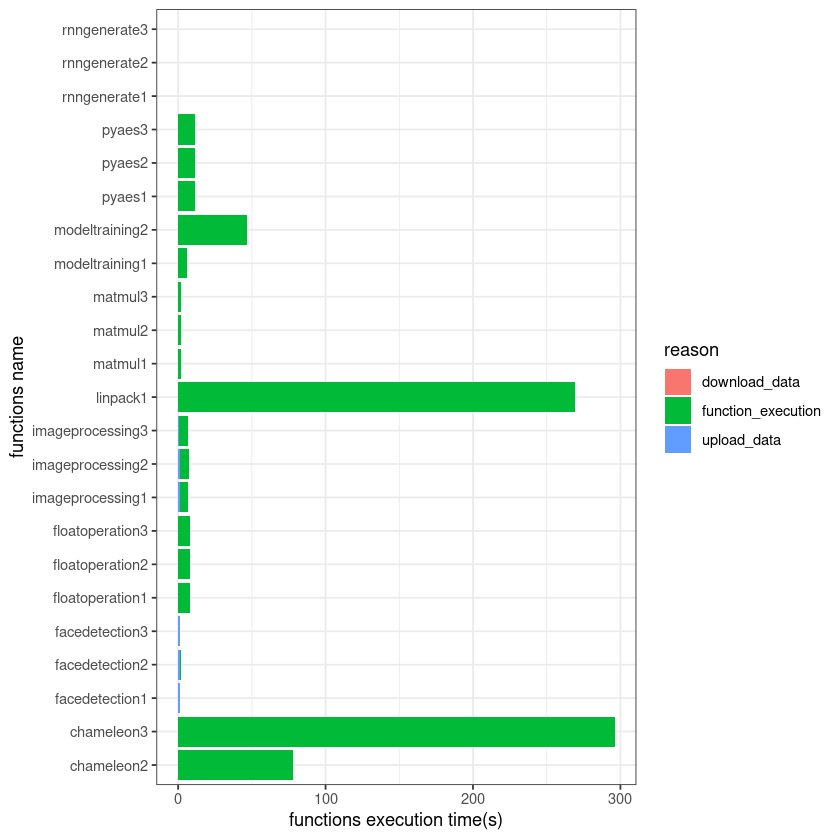

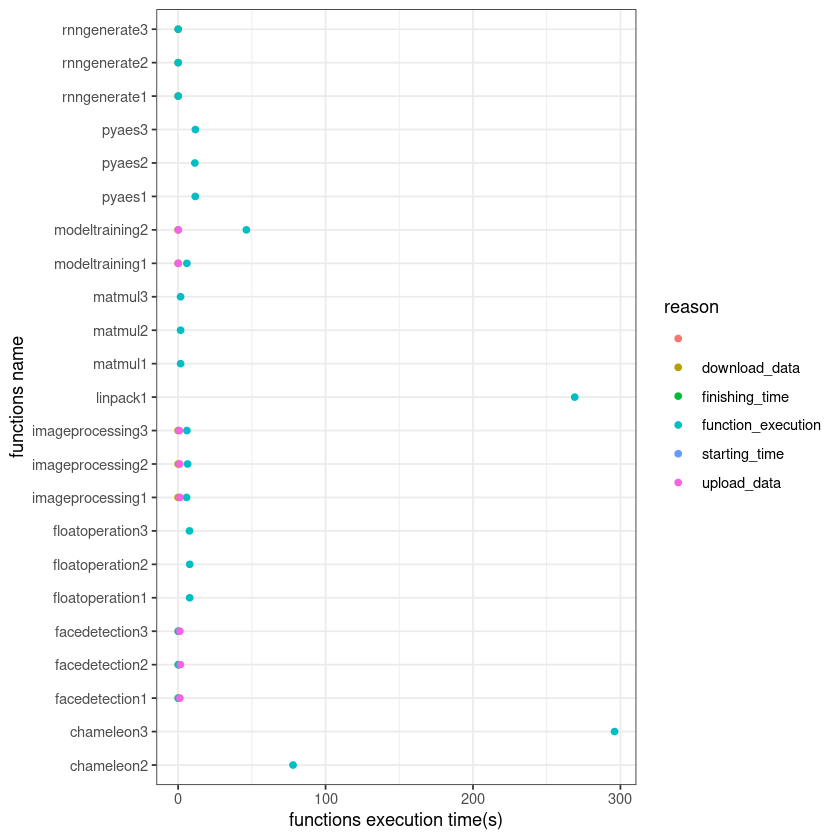

In [8]:
str(df_activations_selected)
df_plot <- df_activations_selected

ggplot(data = df_plot) +
   geom_bar(aes(x = duration, y = function_name, fill = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_bar_plot.png')

ggplot(data = df_plot) +
   geom_point(aes(x = duration, y = function_name, color = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_point_plot.png')

In [17]:
### Spread the timestamps of activations by categories

In [9]:
df_spread_activations <- df_activations_selected %>%
   group_by_at(vars(-duration)) %>%
   mutate(sample_id = row_number()) %>% ungroup() %>%
   spread(reason, duration) %>%
   select(-sample_id, -node, -object_uid)

head(df_spread_activations)
tail(df_spread_activations)

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


function_name   V1 download_data finishing_time function_execution
1 chameleon2      NA        NA     NA              77.9584277       
2 chameleon3      NA        NA     NA             296.0382054       
3 facedetection1  NA 0.1099904     NA               0.1099904       
4 facedetection2  NA 0.1193242     NA               0.1193242       
5 facedetection3  NA 0.1293817     NA               0.1293817       
6 floatoperation1 NA        NA     NA               7.8390591       
  starting_time upload_data
1 NA                  NA   
2 NA                  NA   
3 NA            1.215871   
4 NA            1.590473   
5 NA            1.185802   
6 NA                  NA

function_name V1 download_data finishing_time function_execution
1 pyaes1        NA         NA    NA             11.61261392       
2 pyaes2        NA         NA    NA             11.34077454       
3 pyaes3        NA         NA    NA             11.72190571       
4 rnngenerate1  NA 0.03427720    NA              0.03610063       
5 rnngenerate2  NA 0.03133726    NA              0.03367901       
6 rnngenerate3  NA 0.03256512    NA              0.03372884       
  starting_time upload_data
1 NA            NA         
2 NA            NA         
3 NA            NA         
4 NA            NA         
5 NA            NA         
6 NA            NA

In [19]:
### Merge the activations and events data

In [20]:
# That occurs some error with imageprocessing2 from Kubernetes side, it was not registered its node.
#df_spread_activations <- df_spread_activations %>% filter(function_name != 'imageprocessing2')

In [10]:
df_events_to_join <- df_processed #%>% mutate(id = row_number())
head(df_events_to_join)
df_activations_to_join <- df_spread_activations #%>% mutate(id = row_number())
head(df_activations_to_join)

df_all <- full_join(
   df_events_to_join,
   df_activations_to_join,
   by="function_name") %>%
   distinct()
#df_all[is.na(df_all)] = 0

summary(df_all)

function_name   node                          container_image_downloading
1 chameleon2      paranoia-8.rennes.grid5000.fr 23                         
2 chameleon3      paranoia-2.rennes.grid5000.fr 10                         
3 facedetection1  paranoia-8.rennes.grid5000.fr  7                         
4 facedetection2  paranoia-8.rennes.grid5000.fr NA                         
5 facedetection3  paranoia-8.rennes.grid5000.fr NA                         
6 floatoperation1 paranoia-8.rennes.grid5000.fr 14                         
  container_image_creation container_initialization
1 3                        0                       
2 3                        1                       
3 1                        1                       
4 0                        0                       
5 0                        1                       
6 2                        1

function_name   V1 download_data finishing_time function_execution
1 chameleon2      NA        NA     NA              77.9584277       
2 chameleon3      NA        NA     NA             296.0382054       
3 facedetection1  NA 0.1099904     NA               0.1099904       
4 facedetection2  NA 0.1193242     NA               0.1193242       
5 facedetection3  NA 0.1293817     NA               0.1293817       
6 floatoperation1 NA        NA     NA               7.8390591       
  starting_time upload_data
1 NA                  NA   
2 NA                  NA   
3 NA            1.215871   
4 NA            1.590473   
5 NA            1.185802   
6 NA                  NA

 function_name          node           container_image_downloading
 Length:23          Length:23          Min.   : 3.00              
 Class :character   Class :character   1st Qu.: 7.00              
 Mode  :character   Mode  :character   Median :12.00              
                                       Mean   :14.47              
                                       3rd Qu.:23.00              
                                       Max.   :34.00              
                                       NA's   :6                  
 container_image_creation container_initialization       V1     
 Min.   :0.00             Min.   :0.0000           Min.   : NA  
 1st Qu.:1.00             1st Qu.:0.0000           1st Qu.: NA  
 Median :2.00             Median :1.0000           Median : NA  
 Mean   :1.87             Mean   :0.7826           Mean   :NaN  
 3rd Qu.:3.00             3rd Qu.:1.0000           3rd Qu.: NA  
 Max.   :7.00             Max.   :2.0000           Max.   : NA  
         

In [11]:
df_gathered <- df_all %>%
    gather(
        factor_key = 'TRUE',
        key = 'reason',
        value = 'duration',
        -function_name, -node) %>%
    drop_na()
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_downloading', '00_container_image_downloading')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_creation', '01_container_image_creation')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_initialization', '02_container_initialization')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'download_data', '03_download_data')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'function_execution', '04_function_execution')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'upload_data', '05_upload_data')

df_plot <- df_gathered
summary(df_plot)
head(df_plot)
tail(df_plot)

 function_name          node              reason             duration      
 Length:105         Length:105         Length:105         Min.   :  0.000  
 Class :character   Class :character   Class :character   1st Qu.:  0.110  
 Mode  :character   Mode  :character   Mode  :character   Median :  1.030  
                                                          Mean   : 10.397  
                                                          3rd Qu.:  5.936  
                                                          Max.   :296.038  

function_name   node                          reason                        
1 chameleon2      paranoia-8.rennes.grid5000.fr 00_container_image_downloading
2 chameleon3      paranoia-2.rennes.grid5000.fr 00_container_image_downloading
3 facedetection1  paranoia-8.rennes.grid5000.fr 00_container_image_downloading
4 floatoperation1 paranoia-8.rennes.grid5000.fr 00_container_image_downloading
5 floatoperation2 paranoia-8.rennes.grid5000.fr 00_container_image_downloading
6 floatoperation3 paranoia-2.rennes.grid5000.fr 00_container_image_downloading
  duration
1 23      
2 10      
3  7      
4 14      
5 14      
6 12

function_name    node                          reason         duration  
1 facedetection3   paranoia-8.rennes.grid5000.fr 05_upload_data 1.18580198
2 imageprocessing1 paranoia-8.rennes.grid5000.fr 05_upload_data 1.20802164
3 imageprocessing2 paranoia-8.rennes.grid5000.fr 05_upload_data 1.03002405
4 imageprocessing3 paranoia-8.rennes.grid5000.fr 05_upload_data 0.80044222
5 modeltraining1   paranoia-8.rennes.grid5000.fr 05_upload_data 0.04825640
6 modeltraining2   paranoia-8.rennes.grid5000.fr 05_upload_data 0.09723639

In [12]:
a <- df_plot %>% filter(function_name == 'linpack3')
print(a)

# A tibble: 0 x 4
# Groups:   function_name [0]
# … with 4 variables: function_name <chr>, node <chr>, reason <chr>,
#   duration <dbl>


In [24]:
### Plot the merged data

Saving 6.67 x 6.67 in image



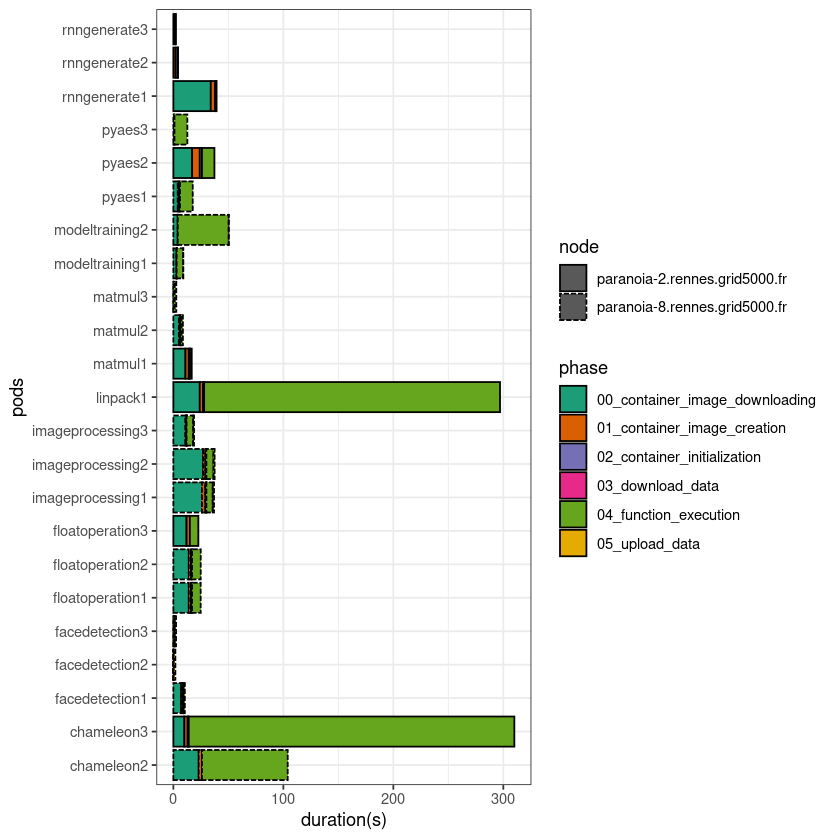

In [13]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack.png')

Saving 6.67 x 6.67 in image



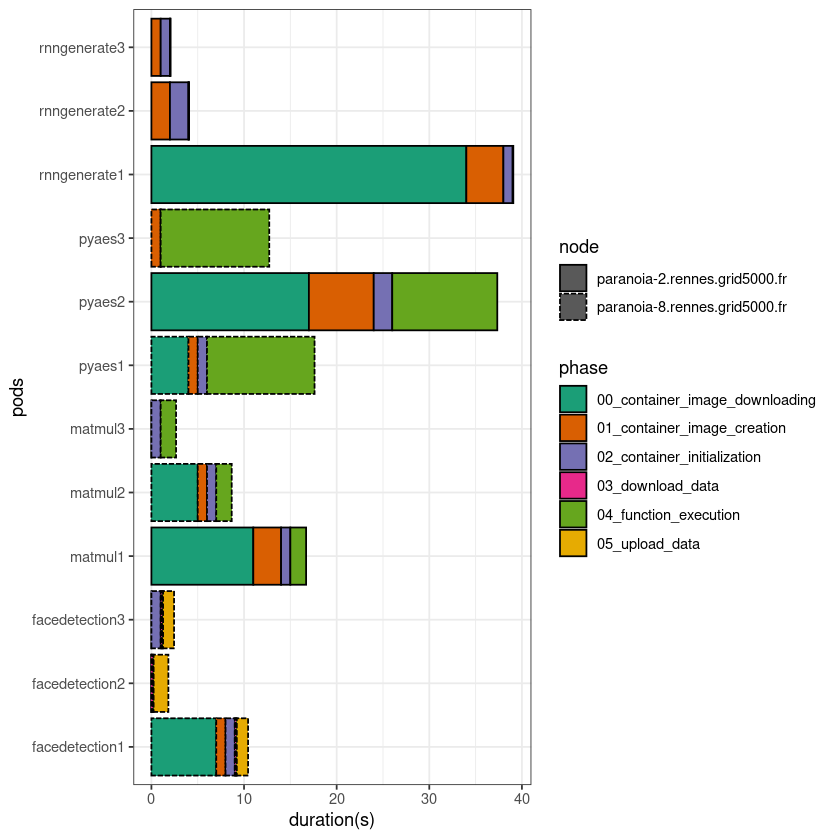

In [22]:
df_plot2 <- df_plot %>% filter(
                              function_name != 'videoprocessing1' & function_name != 'videoprocessing2' & function_name != 'videoprocessing3' &
                              function_name != 'imageprocessing1' & function_name != 'imageprocessing2' & function_name != 'imageprocessing3' &
                              function_name != 'chameleon1' & function_name != 'chameleon2' & function_name != 'chameleon3' &
                              function_name != 'linpack1' & function_name != 'linpack2' & function_name != 'linpack3' &
                              function_name != 'floatoperation1' & function_name != 'floatoperation2' & function_name != 'floatoperation3' &
                              function_name != 'modeltraining1' & function_name != 'modeltraining2' & function_name != 'modeltraining3')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered.png')

Saving 6.67 x 6.67 in image



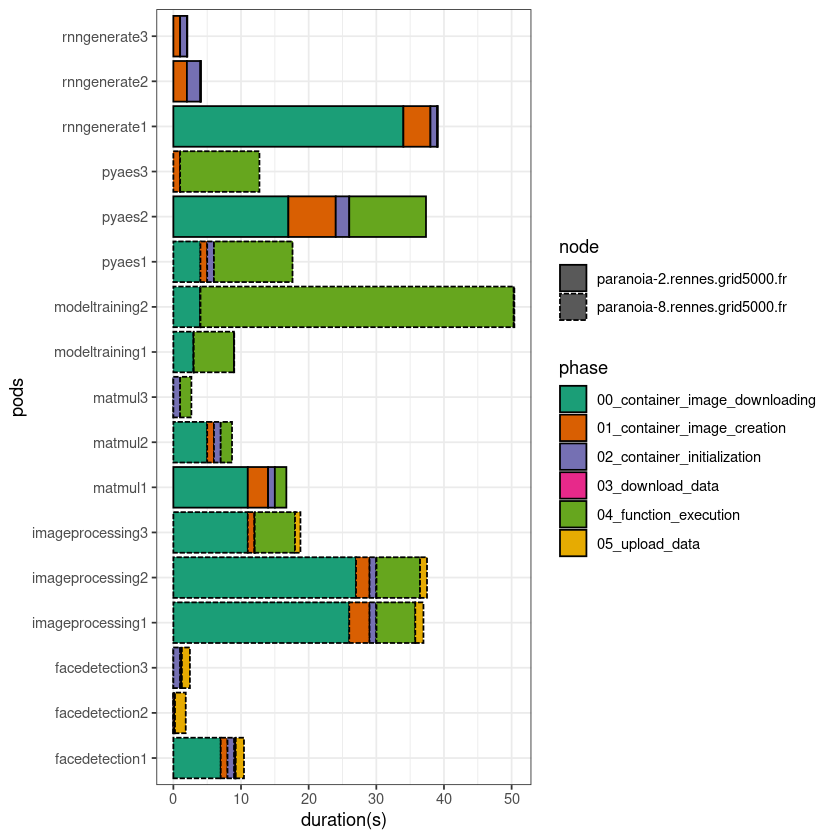

In [23]:
df_plot2 <- df_plot %>% filter(
                              function_name != 'videoprocessing1' & function_name != 'videoprocessing2' & function_name != 'videoprocessing3' &
                              #function_name != 'imageprocessing1' & function_name != 'imageprocessing2' & function_name != 'imageprocessing3' &
                              function_name != 'chameleon1' & function_name != 'chameleon2' & function_name != 'chameleon3' &
                              function_name != 'linpack1' & function_name != 'linpack2' & function_name != 'linpack3' &
                              function_name != 'floatoperation1' & function_name != 'floatoperation2' & function_name != 'floatoperation3')# &
                              #function_name != 'modeltraining1' & function_name != 'modeltraining2' & function_name != 'modeltraining3')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered2.png')

Saving 6.67 x 6.67 in image



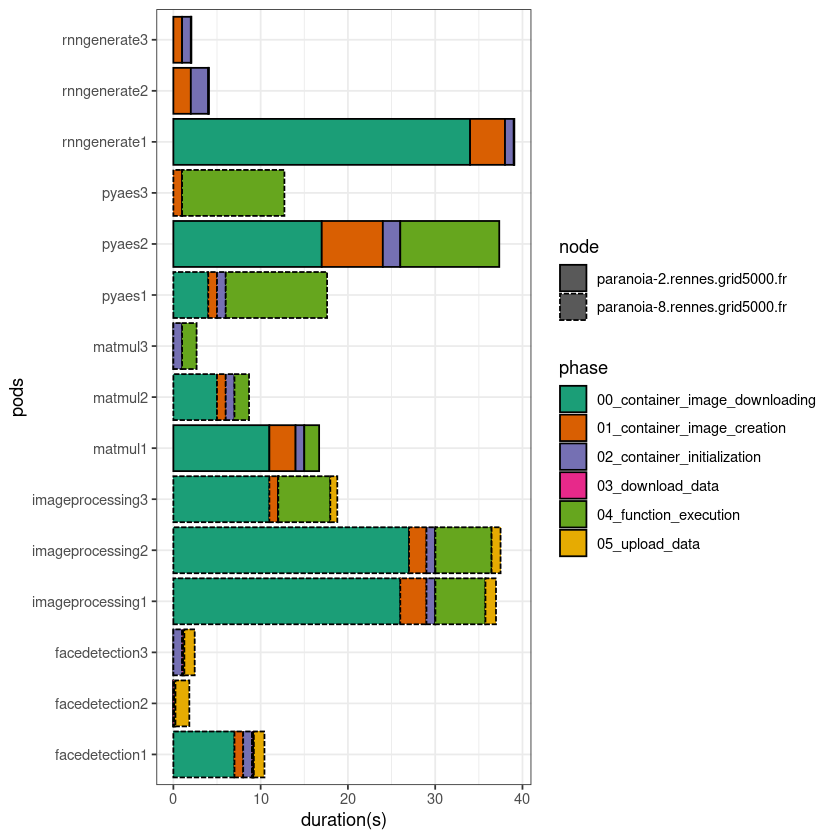

In [25]:
df_plot2 <- df_plot %>% filter(
                              function_name != 'videoprocessing1' & function_name != 'videoprocessing2' & function_name != 'videoprocessing3' &
                              #function_name != 'imageprocessing1' & function_name != 'imageprocessing2' & function_name != 'imageprocessing3' &
                              function_name != 'chameleon1' & function_name != 'chameleon2' & function_name != 'chameleon3' &
                              function_name != 'linpack1' & function_name != 'linpack2' & function_name != 'linpack3' &
                              function_name != 'floatoperation1' & function_name != 'floatoperation2' & function_name != 'floatoperation3' &
                              function_name != 'modeltraining1' & function_name != 'modeltraining2' & function_name != 'modeltraining3')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered3.png')

Saving 6.67 x 6.67 in image



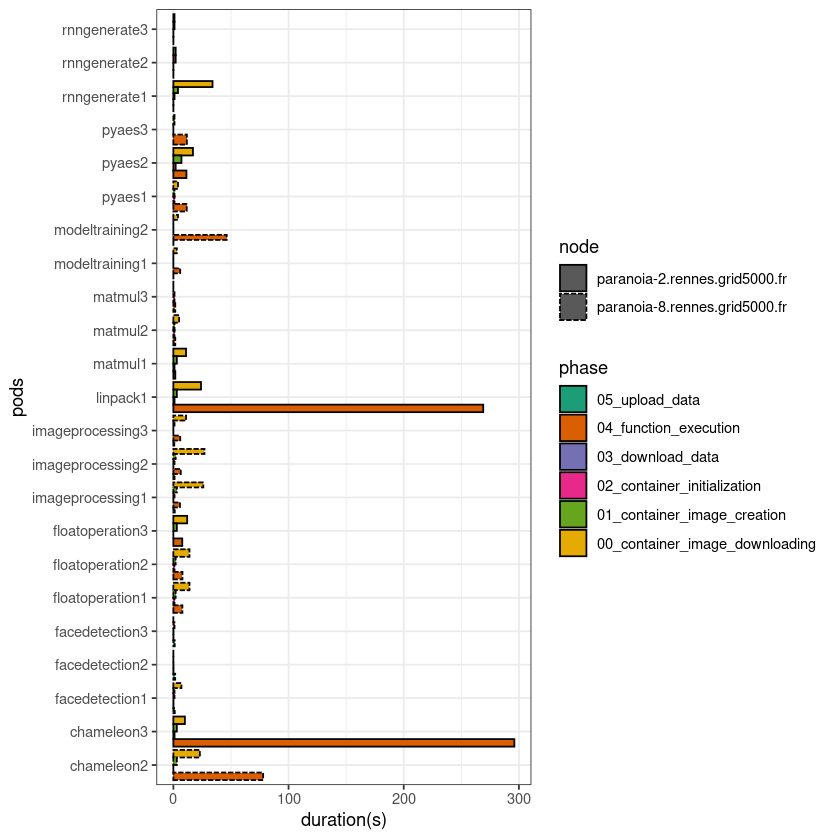

In [15]:
ggplot(data = df_plot, aes(x = duration, y = function_name, linetype = node,
                           fill = factor(reason, levels = rev(c("00_container_image_downloading",
                                  "01_container_image_creation", 
                                  "02_container_initialization", 
                                  "03_download_data", 
                                  "04_function_execution", 
                                  "05_upload_data"))))) +#, color = node)) +
   geom_bar(position="dodge", stat='identity', color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   scale_fill_brewer(palette = "Dark2") +
   #guides(fill = guide_legend(reverse = TRUE))
   ggsave('full_bar_plot_dodge.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 12 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 12 rows containing missing values (geom_bar).”


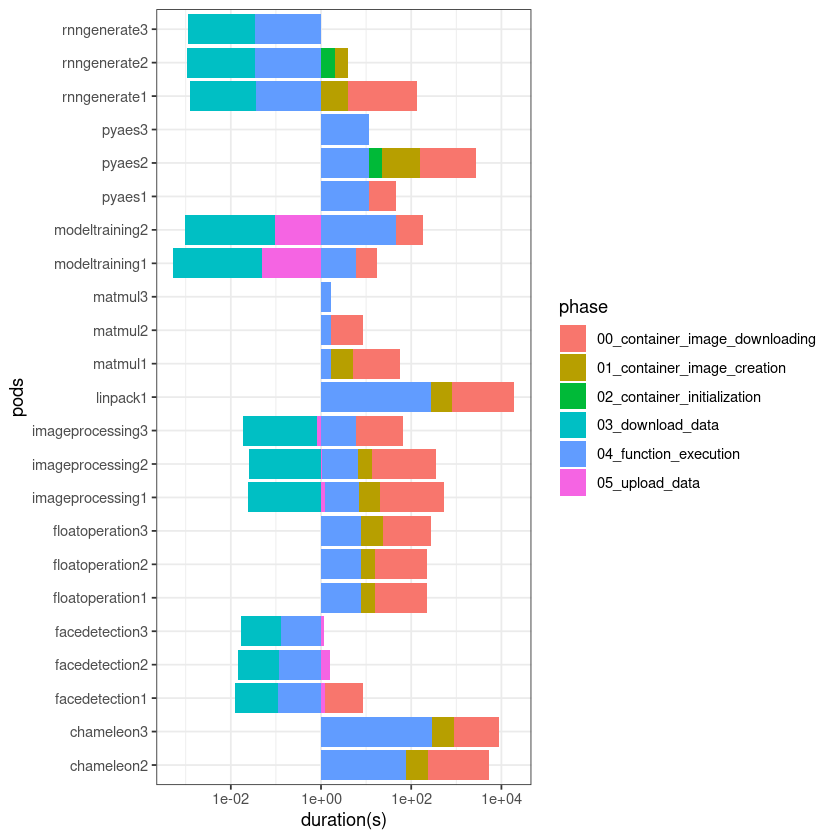

In [16]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason))+#, color = node)) +
   geom_bar(stat='identity')  +
    scale_x_log10() +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   ggsave('full_bar_plot_log10.png')

Saving 6.67 x 6.67 in image



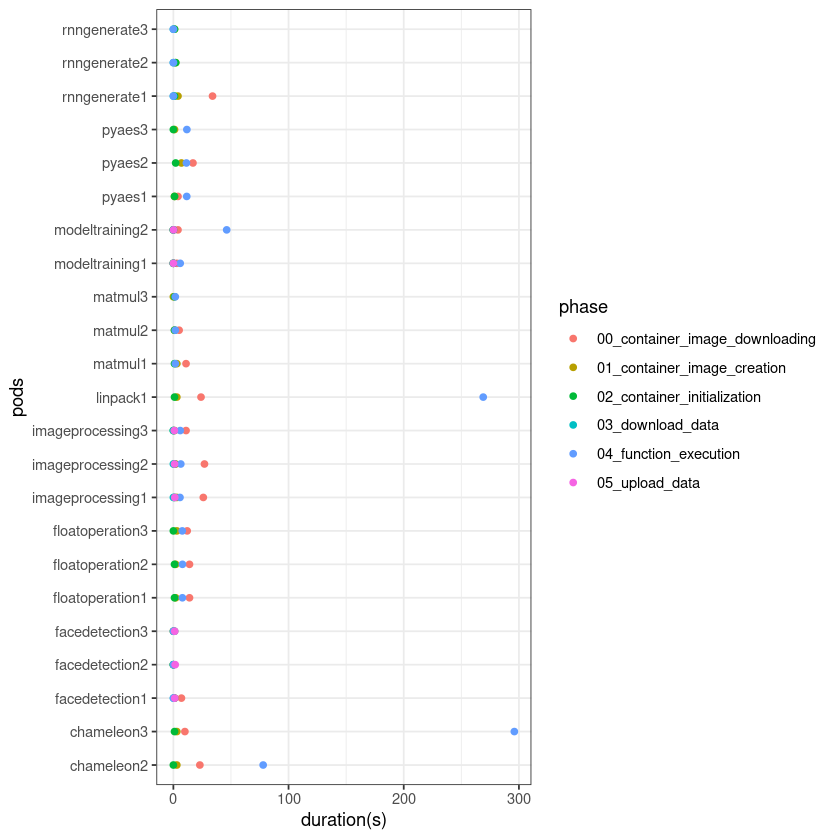

In [17]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s)", y = "pods", color = "phase") +
    theme_bw() +
    ggsave('full_geom_point.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


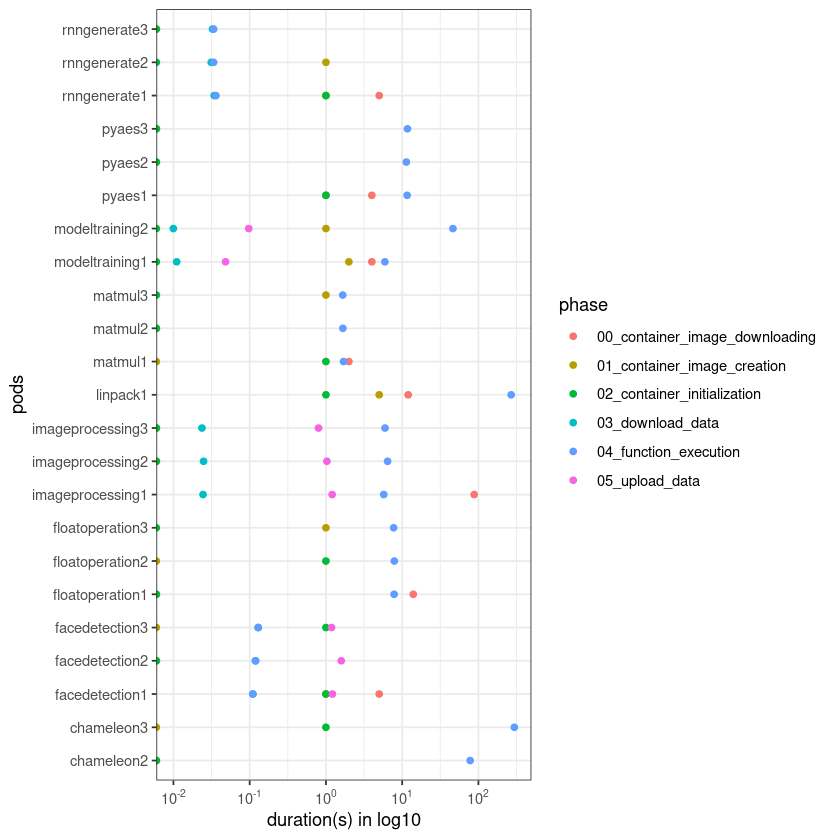

In [30]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s) in log10", y = "pods", color = "phase") +
    scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    theme_bw() +
    ggsave('full_geom_point_log10.png')